<a href="https://colab.research.google.com/github/aviramberg276/scout_exp/blob/develop/palyers_detectors_tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install Detectron:

In [ ]:
# install Detectron https://gilberttanner.com/blog/detectron-2-object-detection-with-pytorch
!pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html

# Pose Detection with OpenPose

This notebook uses an open source project [CMU-Perceptual-Computing-Lab/openpose](https://github.com/CMU-Perceptual-Computing-Lab/openpose.git) to detect/track multi person poses on a given youtube video.

For other deep-learning Colab notebooks, visit [tugstugi/dl-colab-notebooks](https://github.com/tugstugi/dl-colab-notebooks).


## Install OpenPose

In [ ]:
import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/CMU-Perceptual-Computing-Lab/openpose.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # see: https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/949
  # install new CMake becaue of CUDA10
  !wget -q https://cmake.org/files/v3.13/cmake-3.13.0-Linux-x86_64.tar.gz
  !tar xfz cmake-3.13.0-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local
  # clone openpose
  !git clone -q --depth 1 $git_repo_url
  !sed -i 's/execute_process(COMMAND git checkout master WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/execute_process(COMMAND git checkout f019d0dfe86f49d1140961f8c7dec22130c83154 WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/g' openpose/CMakeLists.txt
  # install system dependencies
  !apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev
  # install python dependencies
  !pip install -q youtube-dl
  # build openpose
  !cd openpose && rm -rf build || true && mkdir build && cd build && cmake .. && make -j`nproc`
  
from IPython.display import YouTubeVideo

## Detect poses on a test video

We are going to detect poses on the following youtube video:

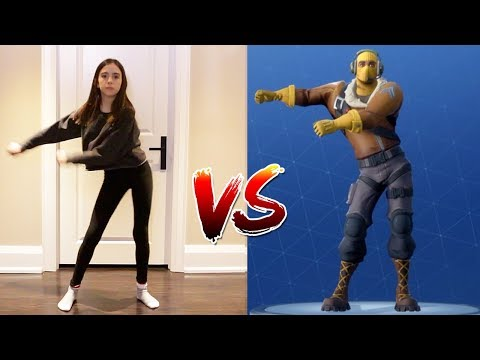

In [ ]:
YOUTUBE_ID = 'RXABo9hm8B8'


YouTubeVideo(YOUTUBE_ID)

Download the above youtube video, cut the first 5 seconds and do the pose detection on that 5 seconds:

In [ ]:
!rm -rf youtube.mp4
# download the youtube with the given ID
!youtube-dl -f 'bestvideo[ext=mp4]' --output "youtube.%(ext)s" https://www.youtube.com/watch?v=$YOUTUBE_ID
# cut the first 5 seconds
!ffmpeg -y -loglevel info -i youtube.mp4 -t 5 video.mp4
# detect poses on the these 5 seconds
!rm openpose.avi
!cd openpose && ./build/examples/openpose/openpose.bin --video ../video.mp4 --write_json ./output/ --display 0  --write_video ../openpose.avi
# convert the result into MP4
!ffmpeg -y -loglevel info -i openpose.avi output.mp4

Finally, visualize the result:

In [ ]:
def show_local_mp4_video(file_name, width=640, height=480):
  import io
  import base64
  from IPython.display import HTML
  video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
  return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
                        <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                      </video>'''.format(width, height, video_encoded.decode('ascii')))

show_local_mp4_video('output.mp4', width=960, height=720)

First Player Detector

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2 import model_zoo
import cv2
import os
import numpy as np
from google.colab.patches import cv2_imshow
from sklearn import cluster

In [ ]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
# outputs = predictor(im)

model_final_f10217.pkl: 178MB [00:14, 12.7MB/s]                           


In [ ]:
cfg_panoptic = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg_panoptic.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_50_3x.yaml"))
cfg_panoptic.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_50_3x.yaml")
predictor = DefaultPredictor(cfg)
# outputs = predictor(im)

model_final_c10459.pkl: 184MB [00:14, 13.0MB/s]                           


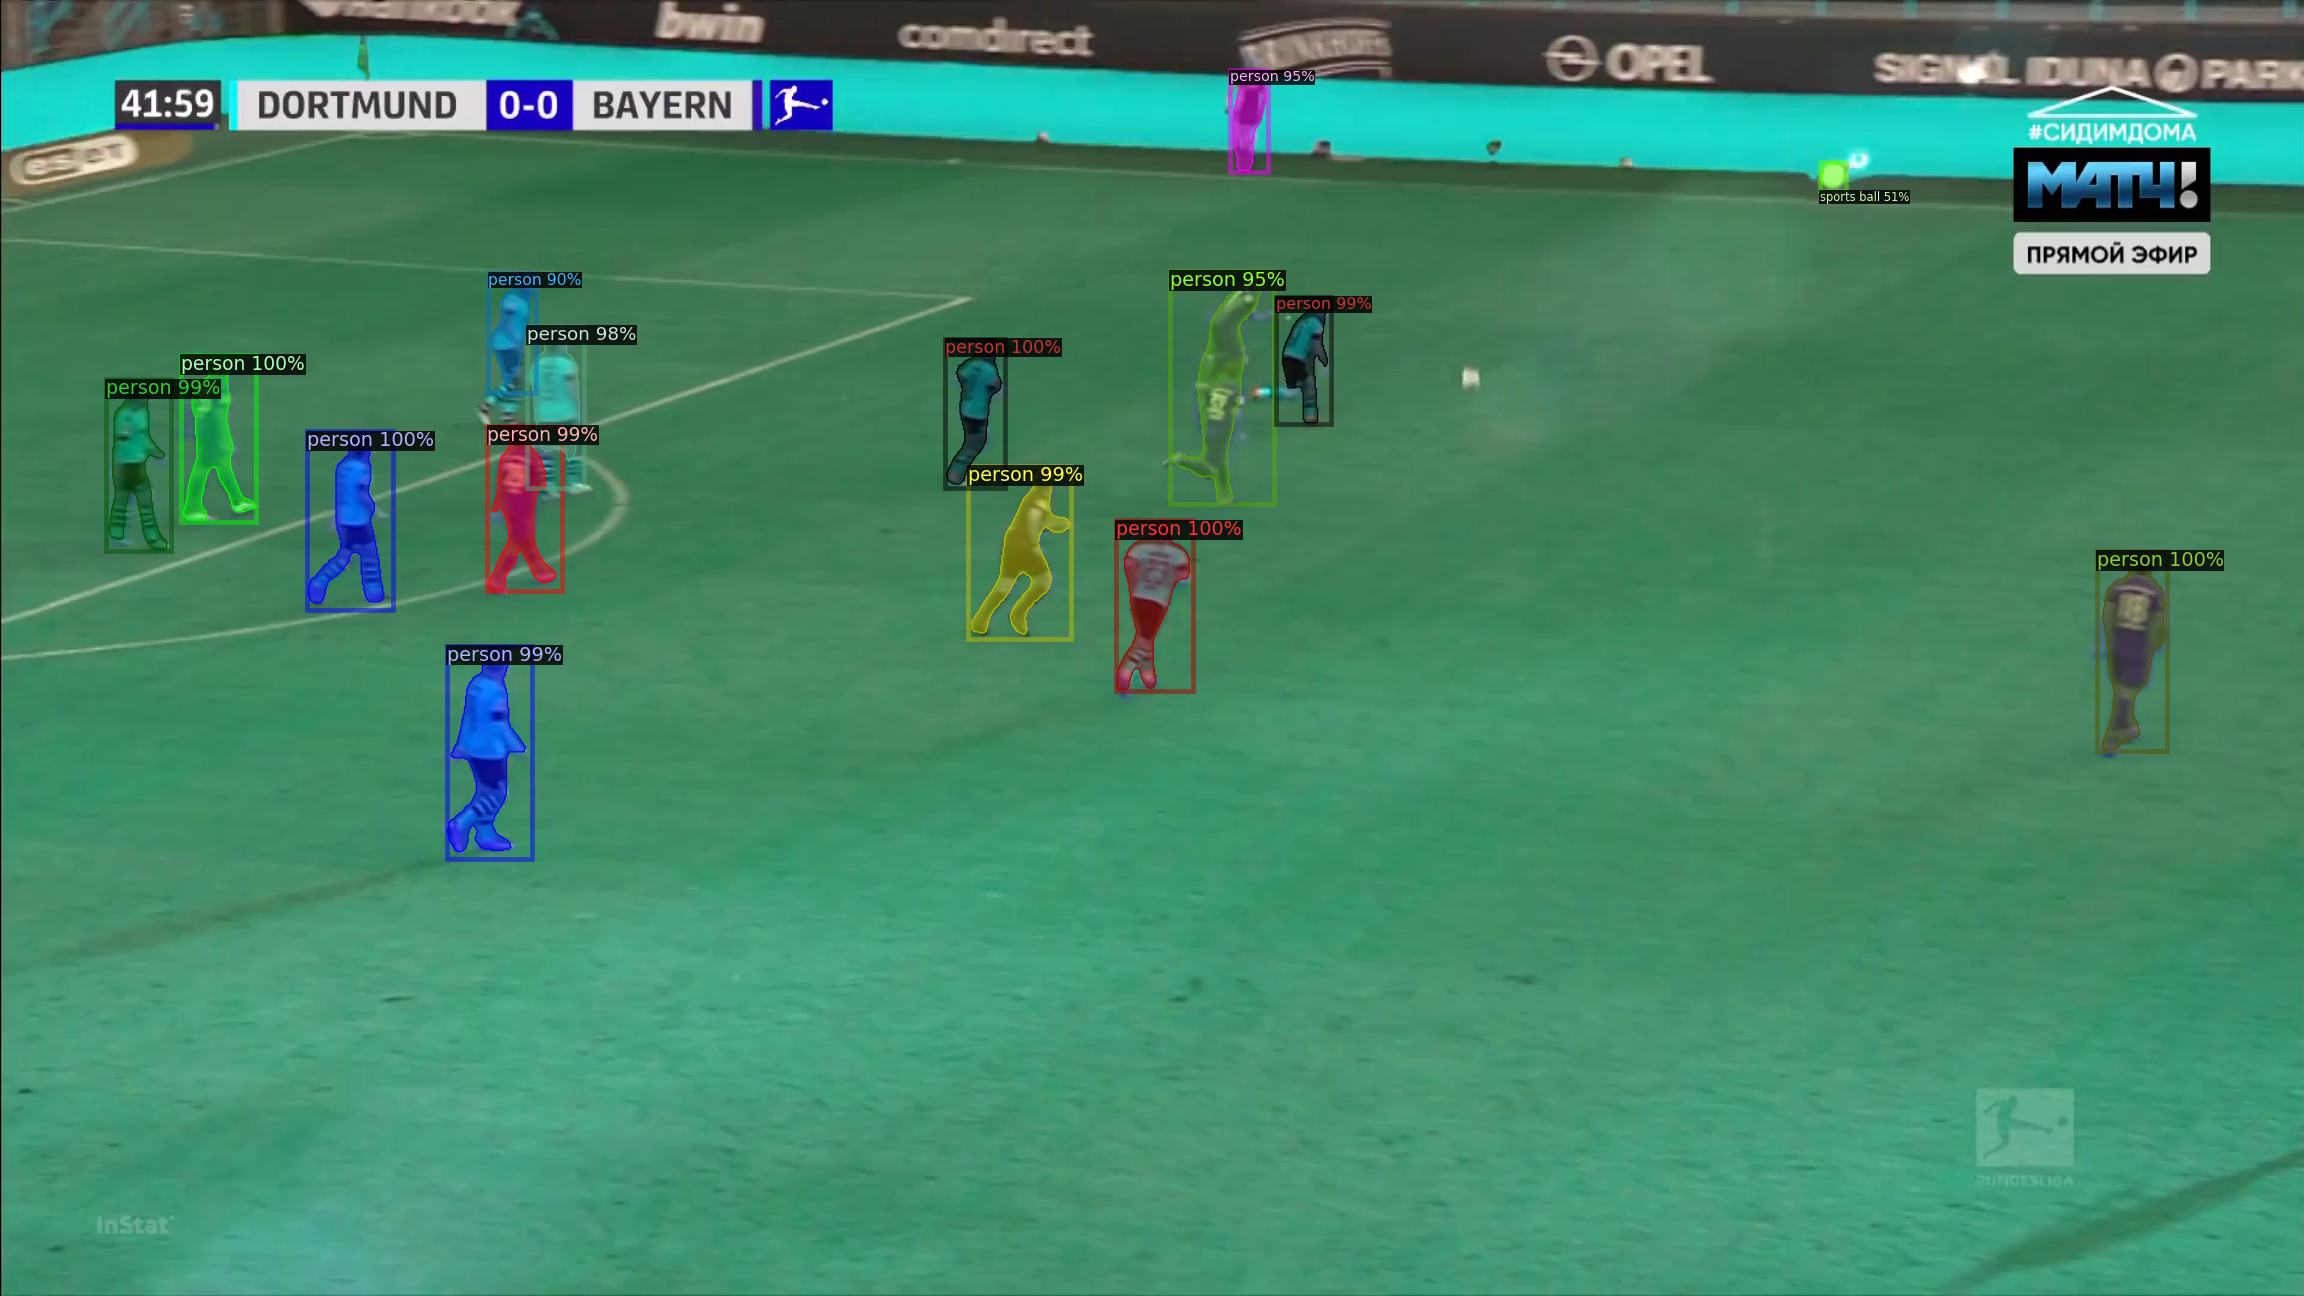

In [ ]:
from detectron2.utils.video_visualizer import VideoVisualizer, _DetectedInstance
from detectron2.data import MetadataCatalog
from detectron2.utils.visualizer import ColorMode, Visualizer

video = cv2.VideoCapture('/content/drive/<path>/goal.mp4')

width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
frames_per_second = video.get(cv2.CAP_PROP_FPS)
num_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
output_file = cv2.VideoWriter(
                '/content/drive/<path>/goal_out.avi',
                # some installation of opencv may not support x264 (due to its license),
                # you can try other format (e.g. MPEG)
                fourcc=cv2.VideoWriter_fourcc(*'XVID'),
                fps=float(frames_per_second),
                frameSize=(width, height),
                isColor=True,
            )

count = 0
success = True
idx = 0
success,image = video.read()
first = image 
while success:
  predictions = predictor(image)
  

  image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
  
  v = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
  v = v.draw_instance_predictions(predictions["instances"].to("cpu"))
  cv2.cvtColor(v.get_image(), cv2.COLOR_RGB2BGR)
  cv2_imshow(v.get_image()[:, :, ::-1])
  output_file.write(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_RGB2BGR))
  count += 1
  if cv2.waitKey(1) & 0xFF == ord('q'):
    break
  success,image = video.read()
  break
  
video.release()
output_file.release()
cv2.waitKey(5)
cv2.destroyAllWindows()

The same frame before detectron effect

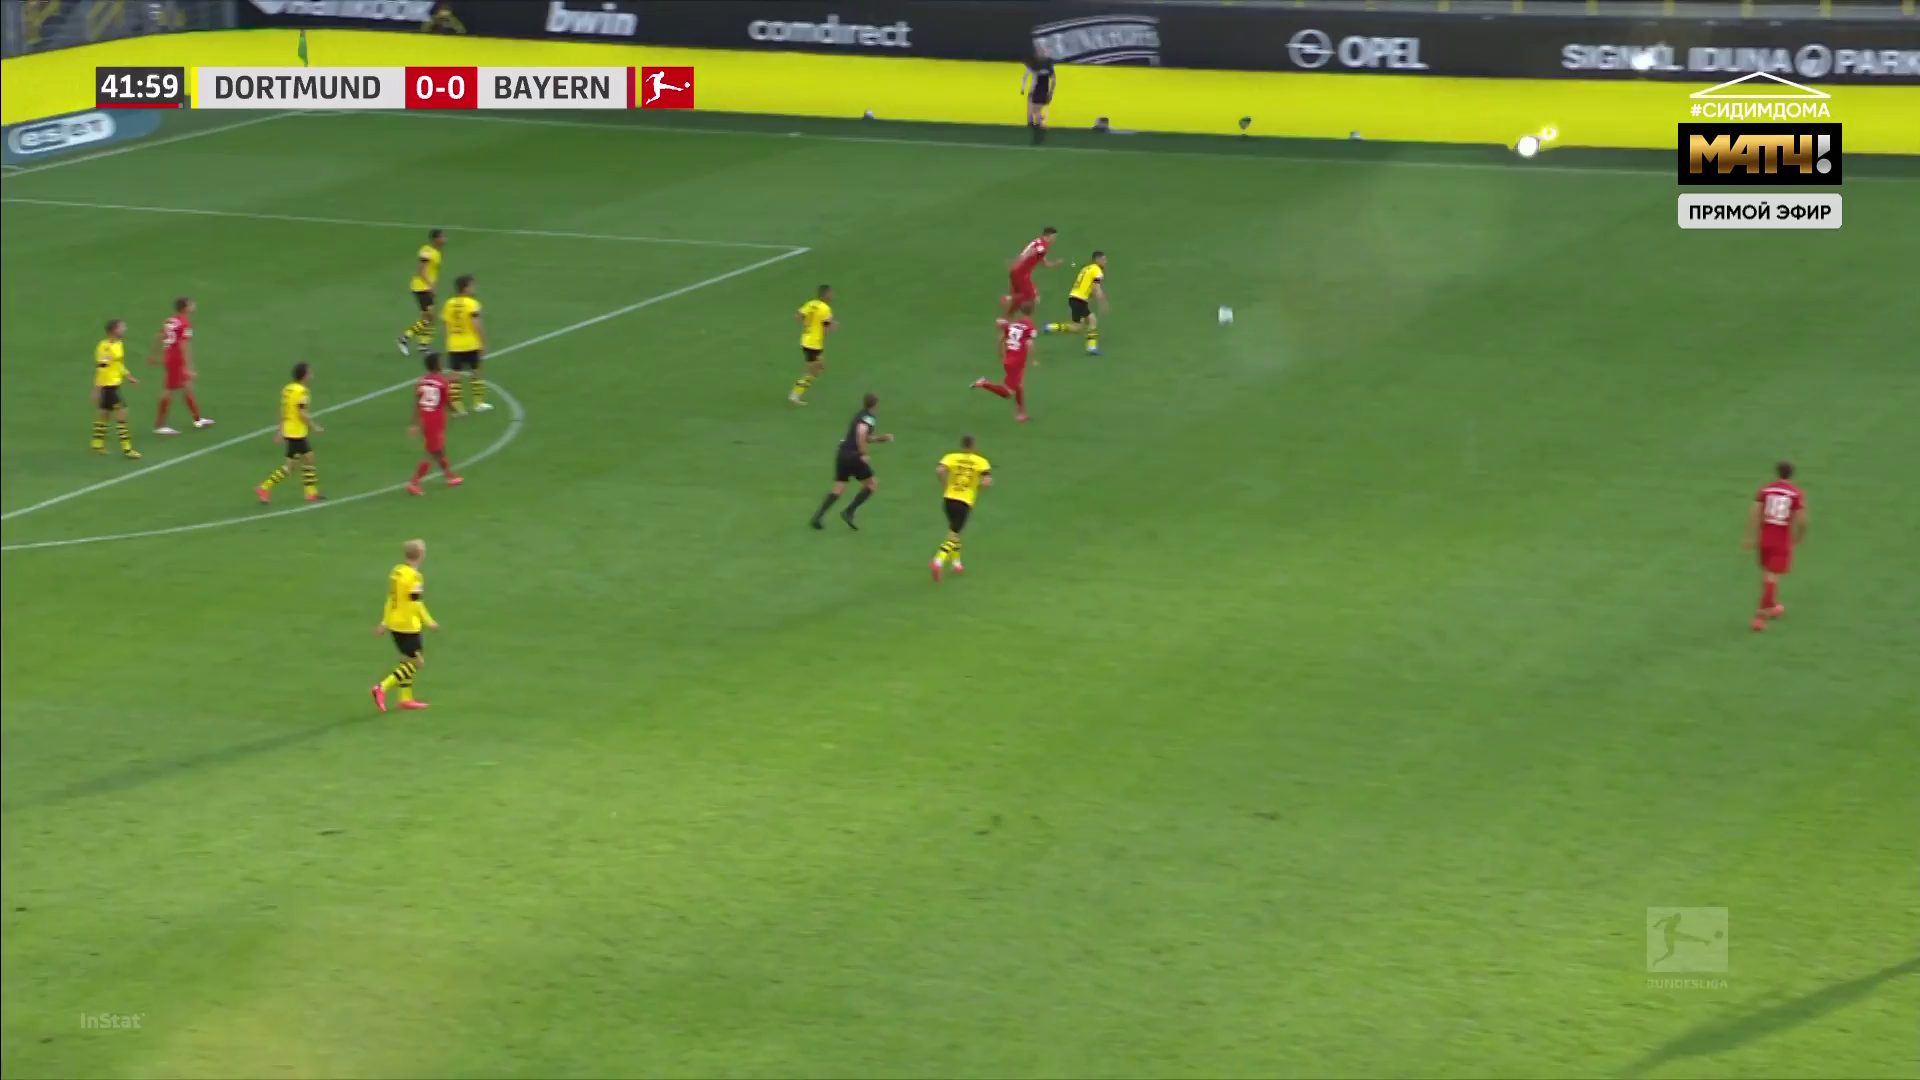

In [ ]:
cv2_imshow(first)

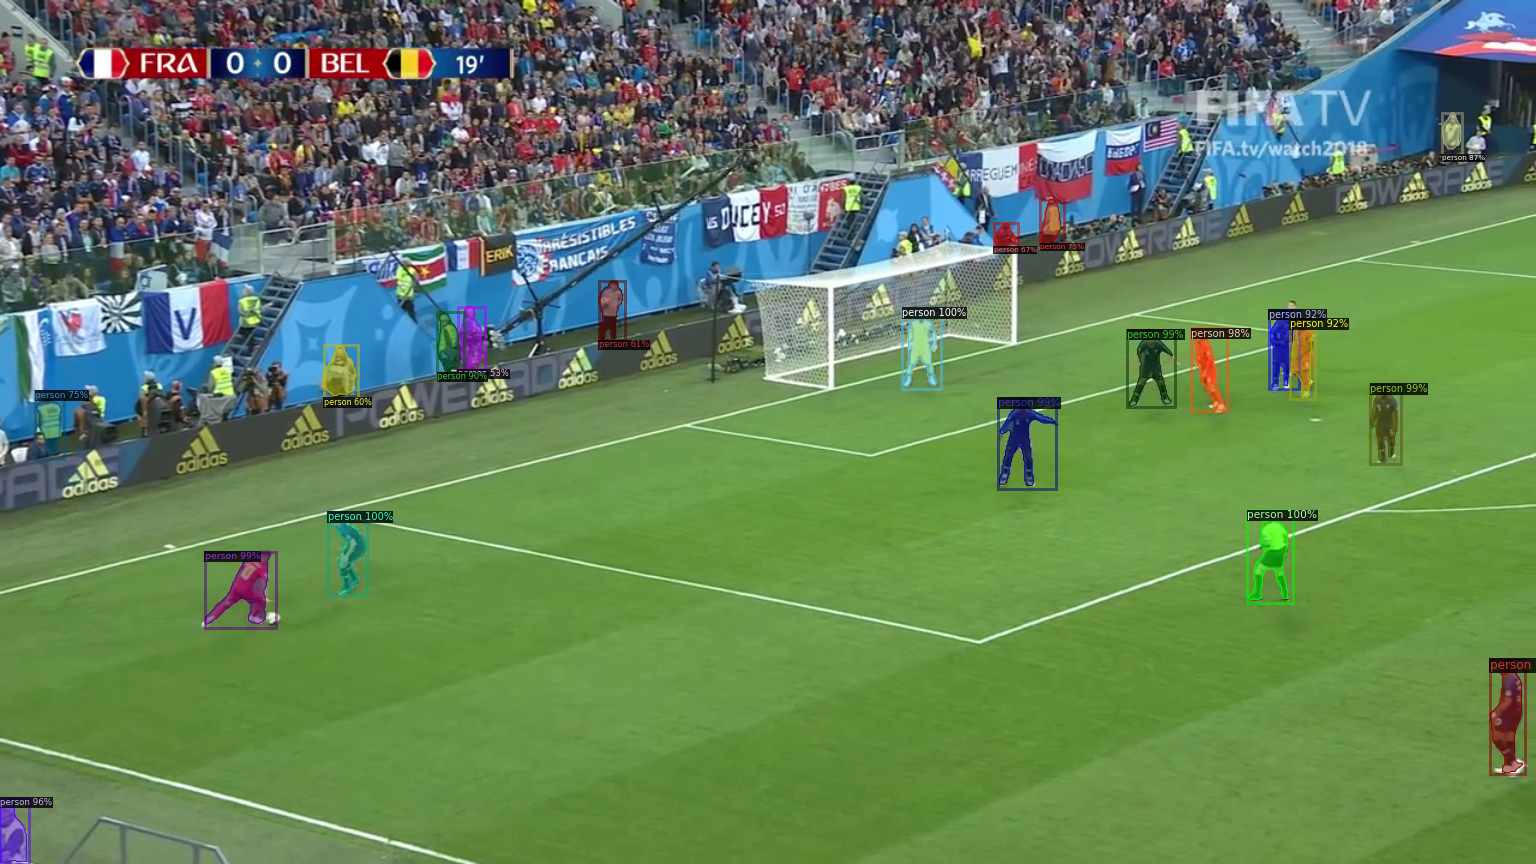

In [ ]:
while success:
  outputs = predictor(image)
  v = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
  v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(v.get_image()[:, :, ::-1])
  out.write(v.get_image()[:, :, ::-1])
  count += 1
  # checking wheather we got interupt from the user the close the image.
  if cv2.waitKey(1) & 0xFF == ord('q'):
    break
  success,image = vidcap.read()
  break
  
vidcap.release()
out.release()
cv2.waitKey(5)
cv2.destroyAllWindows()

In [ ]:
masks = predictions.pred_masks

In [ ]:
# counting the most dominate color
def unique_count_app(a):
    colors, count = np.unique(a.reshape(-1,a.shape[-1]), axis=0, return_counts=True)
    return colors[count.argmax()]

# counting the most dominate color by kmeans
def unique_count_app_k(a):
    colors = []
    kmeans = cluster.KMeans(n_clusters=int(1))
    kmeans.fit(a.reshape(-1,a.shape[-1]) / 255)
    return kmeans.cluster_centers_[0]

Before running the script, you should train the Kmeans algo for the color segmentation. for doing that you need to run the same function for extracting the persons' masks and giving this list for the kmeans. The process should occur in each video you want to predict.

In [ ]:
video = cv2.VideoCapture('/content/drive/<path>/goal.mp4')

width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
frames_per_second = video.get(cv2.CAP_PROP_FPS)
num_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

people_masks = []
count = 0
success = True
idx = 0
success,image = video.read()
first = image 
while success:
  predictions = predictor(image)
  classes = predictions.pred_classes.numpy() if predictions.has("pred_classes") else None
  people_in = np.where(classes==0)[0]
  masks = list(predictions.pred_masks[people_in])
  people_masks +=[unique_count_app_k(a) for a in np.array([image[m] for m in masks])]
  
  count += 1
  if cv2.waitKey(1) & 0xFF == ord('q'):
    break
  success,image = video.read()
  
video.release()
cv2.waitKey(5)
cv2.destroyAllWindows()

Mark close players according to a stub distance value

In [ ]:
from scipy.spatial import distance
import pandas as pd

def compute_distance(midpoints,num):
  dist = np.zeros((num,num))
  for i in range(num):
    for j in range(i+1,num):
      if i!=j:
        dst = distance.euclidean(midpoints[i], midpoints[j])
        dist[i][j]=dst
  return dist


def find_closest(dist,num,thresh):
  p1=[]
  p2=[]
  d=[]
  for i in range(num):
    for j in range(i,num):
      if( (i!=j) & (dist[i][j]<=thresh)):
        p1.append(i)
        p2.append(j)
        d.append(dist[i][j])
  return p1,p2,d



thresh=86
p1,p2,d=find_closest(dist,num,thresh)
df = pd.DataFrame({"p1":p1,"p2":p2,"dist":d})
df

def change_2_red(img,person,p1,p2):
  risky = np.unique(p1+p2)
  for i in risky:
    x1,y1,x2,y2 = person[i]
    _ = cv2.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 2)  
  return img

In [ ]:
class VisualizerUnique(VideoVisualizer):

  def __init__(self, metadata, instance_mode=ColorMode.IMAGE):
    super().__init__(metadata, instance_mode)
    self.kmeans_cluster = cluster.KMeans(n_clusters=int(3))
    self.kmeans_cluster.fit(people_masks)

  def draw_sem_seg(self, sem_seg, area_threshold=None, alpha=0.8):
    """
    Draw semantic segmentation predictions/labels.

    Args:
        sem_seg (Tensor or ndarray): the segmentation of shape (H, W).
            Each value is the integer label of the pixel.
        area_threshold (int): segments with less than `area_threshold` are not drawn.
        alpha (float): the larger it is, the more opaque the segmentations are.

    Returns:
        output (VisImage): image object with visualizations.
    """
    global color
    if isinstance(sem_seg, torch.Tensor):
        sem_seg = sem_seg.numpy()
    labels, areas = np.unique(sem_seg, return_counts=True)
    sorted_idxs = np.argsort(-areas).tolist()
    labels = labels[sorted_idxs]
    for label in filter(lambda l: l < len(self.metadata.stuff_classes), labels):
        try:
            mask_color = [x / 255 for x in self.metadata.stuff_colors[label]]
            color = mask_color
            print(mask_color)
        except (AttributeError, IndexError):
            mask_color = None

        binary_mask = (sem_seg == label).astype(np.uint8)
        text = self.metadata.stuff_classes[label]
        self.draw_binary_mask(
            binary_mask,
            color=mask_color,
            edge_color=_OFF_WHITE,
            text=text,
            alpha=alpha,
            area_threshold=area_threshold,
        )
    return self.output

  def draw_instance_predictions(self, frame, predictions):
    """
    Draw instance-level prediction results on an image.
    Args:
        frame (ndarray): an RGB image of shape (H, W, C), in the range [0, 255].
        predictions (Instances): the output of an instance detection/segmentation
            model. Following fields will be used to draw:
            "pred_boxes", "pred_classes", "scores", "pred_masks" (or "pred_masks_rle").
    Returns:
        output (VisImage): image object with visualizations.
    """

    frame_visualizer = Visualizer(frame, self.metadata)
    num_instances = len(predictions)
    if num_instances == 0:
        return frame_visualizer.output

    boxes = predictions.pred_boxes.tensor.numpy() if predictions.has("pred_boxes") else None
    scores = predictions.scores if predictions.has("scores") else None
    classes = predictions.pred_classes.numpy() if predictions.has("pred_classes") else None
    keypoints = predictions.pred_keypoints if predictions.has("pred_keypoints") else None

    if predictions.has("pred_masks"):
        masks = predictions.pred_masks
        # mask IOU is not yet enabled
        # masks_rles = mask_util.encode(np.asarray(masks.permute(1, 2, 0), order="F"))
        # assert len(masks_rles) == num_instances
    else:
        masks = None

    detected = [
        _DetectedInstance(classes[i], boxes[i], mask_rle=None, color=None, ttl=8)
        for i in range(num_instances)
    ]
    colors = self._assign_colors(detected)
    colors = self.colorize_objects(detected, frame, predictions)

    labels = None #_create_text_labels(classes, scores, self.metadata.get("thing_classes", None))

    if self._instance_mode == ColorMode.IMAGE_BW:
        # any() returns uint8 tensor
        frame_visualizer.output.img = frame_visualizer._create_grayscale_image(
            (masks.any(dim=0) > 0).numpy() if masks is not None else None
        )
        alpha = 0.3
    else:
        alpha = 0.5

    frame_visualizer.overlay_instances(
        boxes=None if masks is not None else boxes,  # boxes are a bit distracting
        masks=masks,
        labels=labels,
        keypoints=keypoints,
        assigned_colors=colors,
        alpha=alpha,
    )
    return frame_visualizer.output

  def colorize_objects(self, detected):
    colors = []
    for d in detected:
      if d.label == 0:
        colors.append(np.array([0., 1., 0.]))
      elif d.label == 32:
        colors.append(np.array([1.   , 0.667, 1.   ]))
      else:
        colors.append(np.array([0.3, 0.3, 0.3]))
    return colors

  def colorize_objects(self, detected, frame, predictions):
    colors = np.array([np.empty(3,) for i in range(len(detected))])
    classes = np.array([d.label for d in detected])
    people_in = np.where(classes==0)[0]
    ball_in = np.where(classes==32)[0]
    other_in = np.array(list(set(range(len(detected))) - set(list(people_in) + list(ball_in)))).astype(int)  

    colors[ball_in] = np.array([1., 0., 0.])
    colors[other_in] = np.array([0.3, 0.3, 0.3])

    people_match_color = np.array([np.empty(3,) for i in range(len(people_in))])
    masks = list(predictions.pred_masks[people_in])
    color_prediction = self.kmeans_cluster.predict([unique_count_app_k(a) for a in np.array([frame[m] for m in masks])])
    people_match_color[np.where(color_prediction == 1)[0]] = np.array([0.466, 0.674, 0.188])
    people_match_color[np.where(color_prediction == 2)[0]] = np.array([1.   , 0.667, 1.   ])
    people_match_color[np.where(color_prediction == 0)[0]] = np.array([0.   , 0.447, 0.741])
    colors[people_in] = people_match_color
    return colors

  def draw_close(self, bbox, classes, img):
    ind = np.where(classes==0)[0]

    #identify bounding box of only persons that close to each other.
    person=bbox[ind]
    midpoints = [mid_point(img,person,i) for i in range(len(person))]
    num= len(person)
    dist= compute_distance(midpoints,num)

    thresh=86
    p1,p2,d=find_closest(dist,num,thresh)
    df = pd.DataFrame({"p1":p1,"p2":p2,"dist":d})
    return change_2_red(img,person,p1,p2)                           
                               

In [ ]:
from detectron2.utils.video_visualizer import VideoVisualizer, _DetectedInstance
from detectron2.data import MetadataCatalog
from detectron2.utils.visualizer import ColorMode, Visualizer
video_visualizer = VisualizerUnique(MetadataCatalog.get(
            cfg.DATASETS.TEST[0] if len(cfg.DATASETS.TEST) else "__unused"
        ))
video = cv2.VideoCapture('/content/drive/<path>/goal.mp4')
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
frames_per_second = video.get(cv2.CAP_PROP_FPS)
num_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
output_file = cv2.VideoWriter(
                '/content/drive/<path>/goal_out.avi',
                # some installation of opencv may not support x264 (due to its license),
                # you can try other format (e.g. MPEG)
                fourcc=cv2.VideoWriter_fourcc(*'XVID'),
                fps=float(frames_per_second),
                frameSize=(width, height),
                isColor=True,
            )

count = 0
success = True
idx = 0
success,image = video.read()
first = image 
while success:
  predictions = predictor(image)
  

  image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
  if "panoptic_seg" in predictions:
      panoptic_seg, segments_info = predictions["panoptic_seg"]
      print("hi2")
      vis_frame = video_visualizer.draw_panoptic_seg_predictions(
          image, panoptic_seg.to("cpu"), segments_info
      )
  if "instances" in predictions:
      predictions = predictions["instances"].to("cpu")
      vis_frame = video_visualizer.draw_instance_predictions(image, predictions)
  elif "sem_seg" in predictions:
      print("hi")
      vis_frame = video_visualizer.draw_sem_seg(
          image, predictions["sem_seg"].argmax(dim=0).to("cpu")
      )
  boxes = predictions.pred_boxes.tensor.numpy() if predictions.has("pred_boxes") else None
  classes = predictions.pred_classes.numpy() if predictions.has("pred_classes") else None
  img = video_visualizer.draw_close(boxes, classes, vis_frame.get_image())
  

  output_file.write(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
  count += 1
  if cv2.waitKey(1) & 0xFF == ord('q'):
    break
  success,image = video.read()
  
video.release()
output_file.release()
cv2.waitKey(5)
cv2.destroyAllWindows()

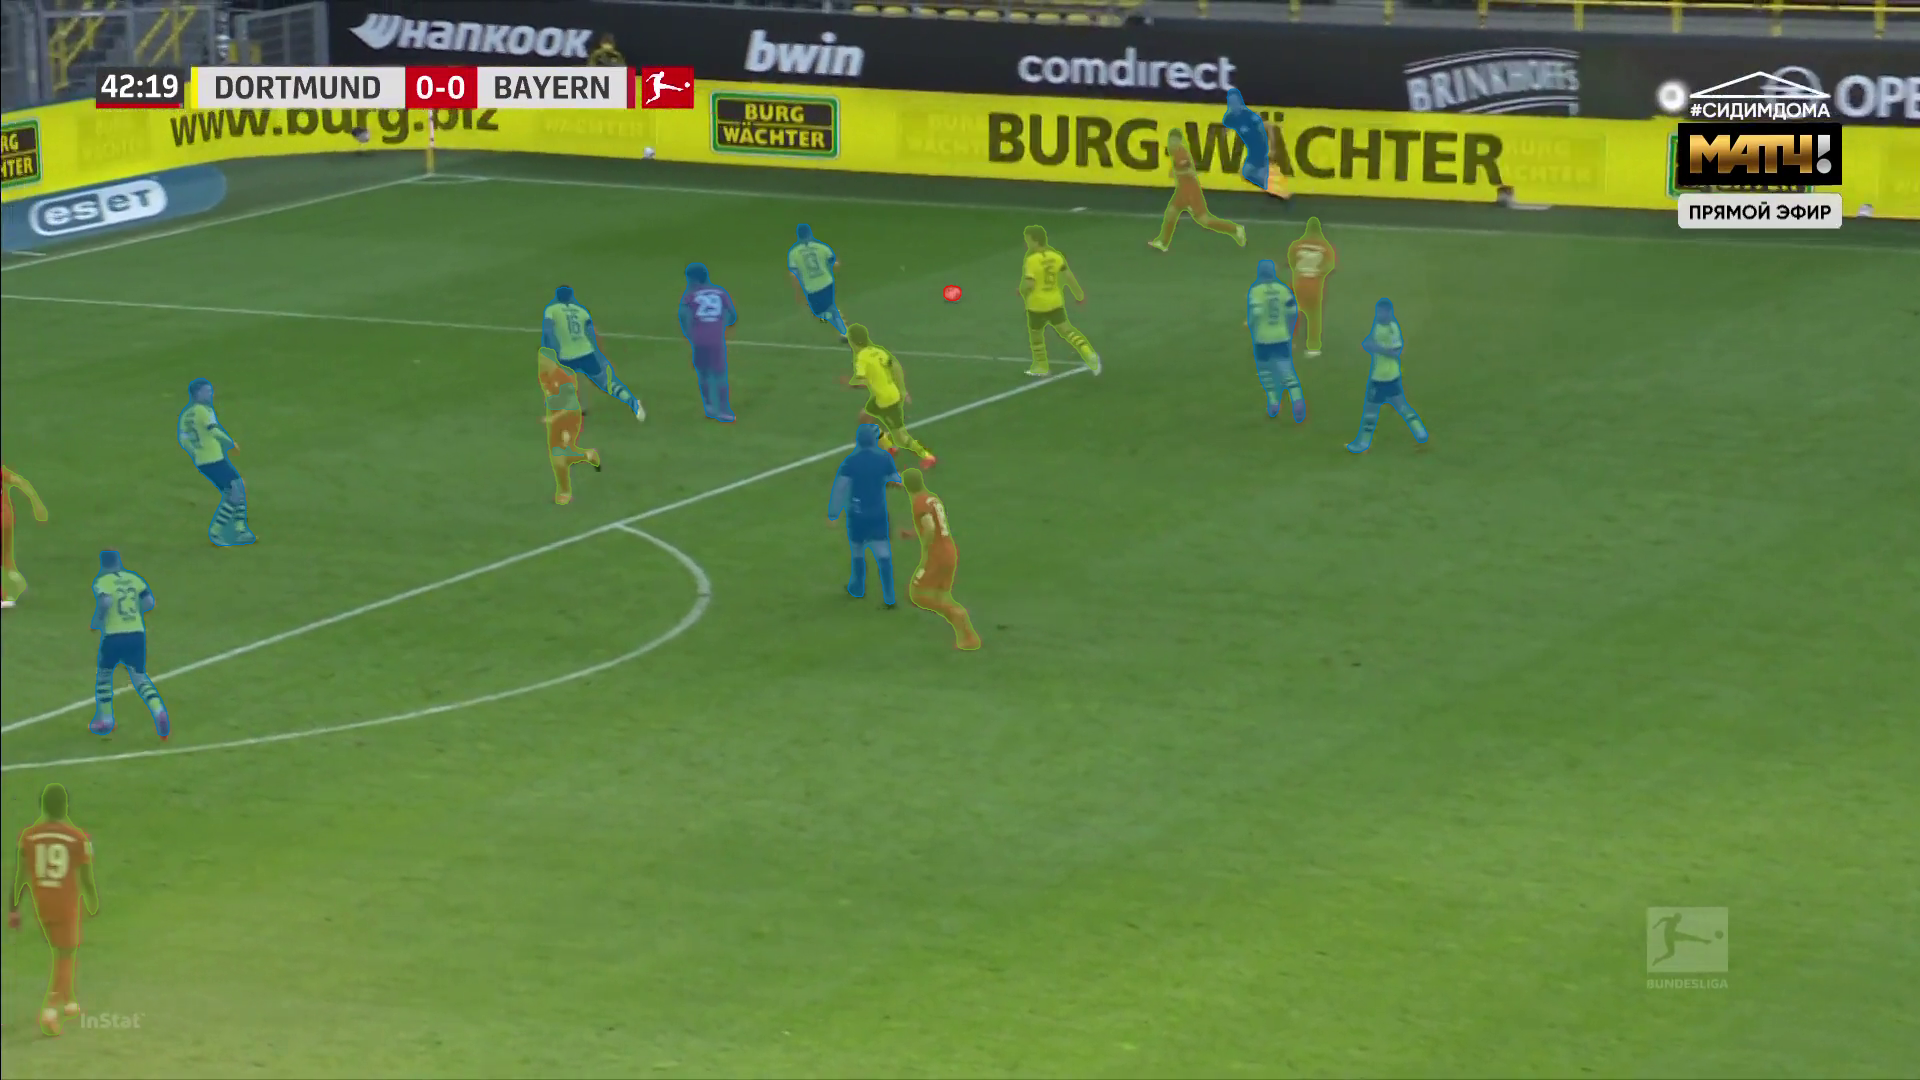

In [ ]:
cv2_imshow(cv2.cvtColor(vis_frame.get_image(), cv2.COLOR_RGB2BGR))

Future directions

In [ ]:
# https://kharshit.github.io/blog/2019/10/18/introduction-to-panoptic-segmentation-tutorial


0


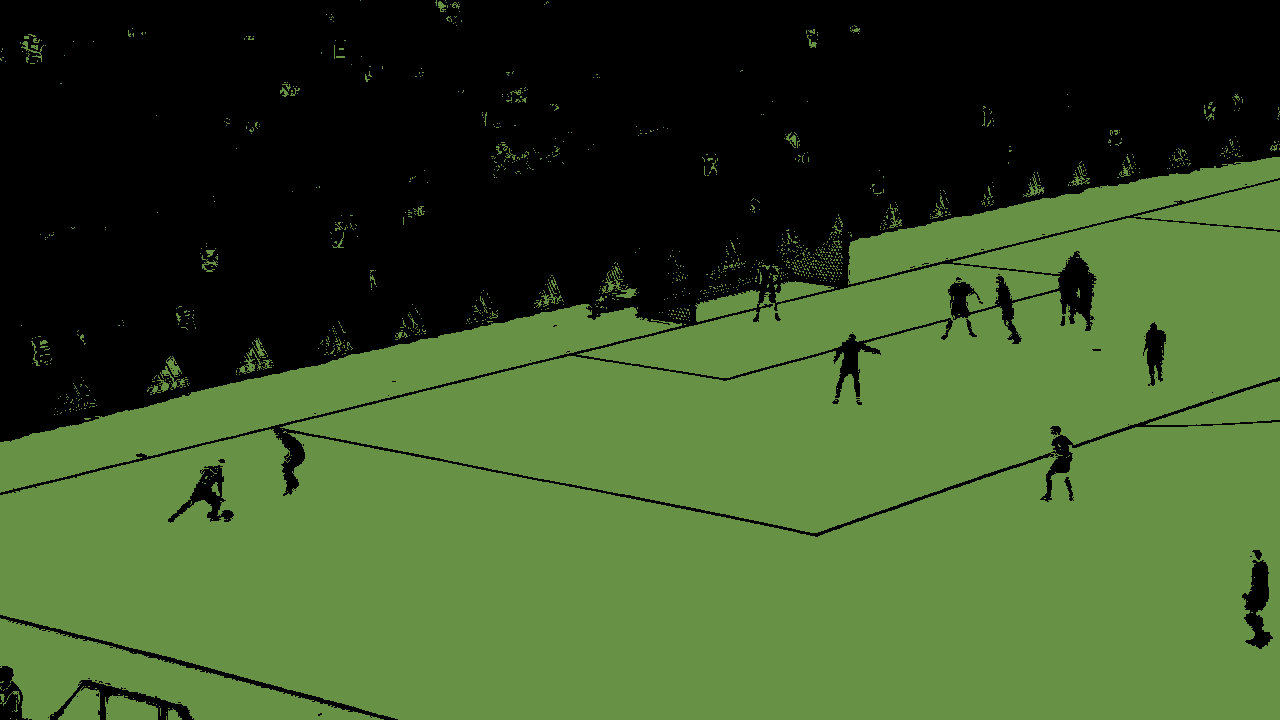

In [ ]:
from skimage import io
from sklearn import cluster
import sys

# read input and convert to range 0-1
# success,image = video.read()
# image = image.copy()
image = first.copy()
image = image/255.0
h, w, c = image.shape

# reshape to 1D array
image_2d = image.reshape(h*w, c)

# set number of colors
numcolors = 6

# do kmeans processing
kmeans_cluster = cluster.KMeans(n_clusters=int(numcolors))
kmeans_cluster.fit(image_2d)
cluster_centers = kmeans_cluster.cluster_centers_
cluster_labels = kmeans_cluster.labels_

# need to scale result back to range 0-255
newimage = cluster_centers[cluster_labels].reshape(h, w, c)*255.0
newimage = newimage.astype('uint8')
# io.imshow(newimage)
# io.show()

# finding the green region
lower_green = np.array([60,100, 100])
upper_green = np.array([70, 255, 255])
for i in range(len(cluster_centers)):
  c = cluster_centers[i]
  if (c*255 > lower_green).all() and (c*255 < upper_green).all():
    print(i)
    break

# select cluster 3 (in range 1 to numcolors) and create mask
lower = cluster_centers[i]*255
upper = cluster_centers[i]*255
lower = lower.astype('uint8')
upper = upper.astype('uint8')
mask = cv2.inRange(newimage, lower, upper)

# apply mask to get layer 3
layer3 = newimage.copy()
layer3[mask == 0] = [0,0,0]
cv2_imshow(layer3)

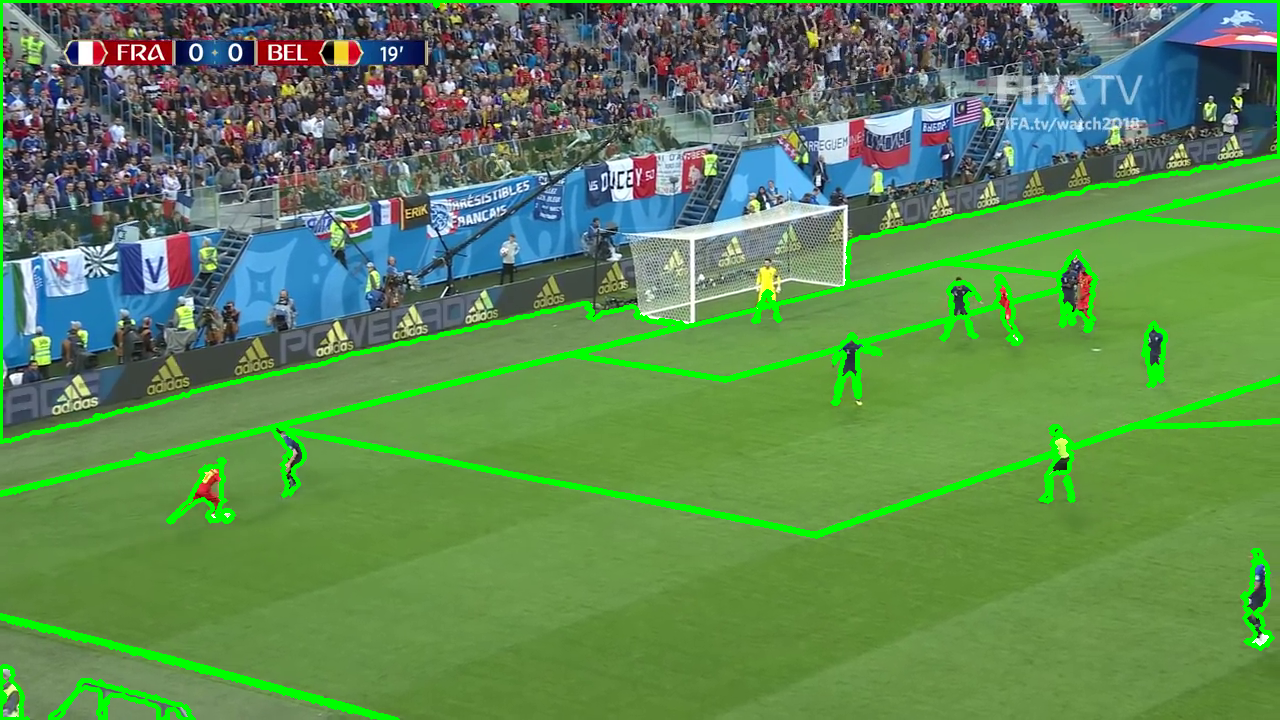

In [ ]:
result = first.copy()
cnts = cv2.findContours(cv2.bitwise_not(mask), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

for c in cnts:
    area = cv2.contourArea(c)
    if area > 10:
        cv2.drawContours(result, [c], -3, (0, 255, 0), 3)


cv2_imshow(result)

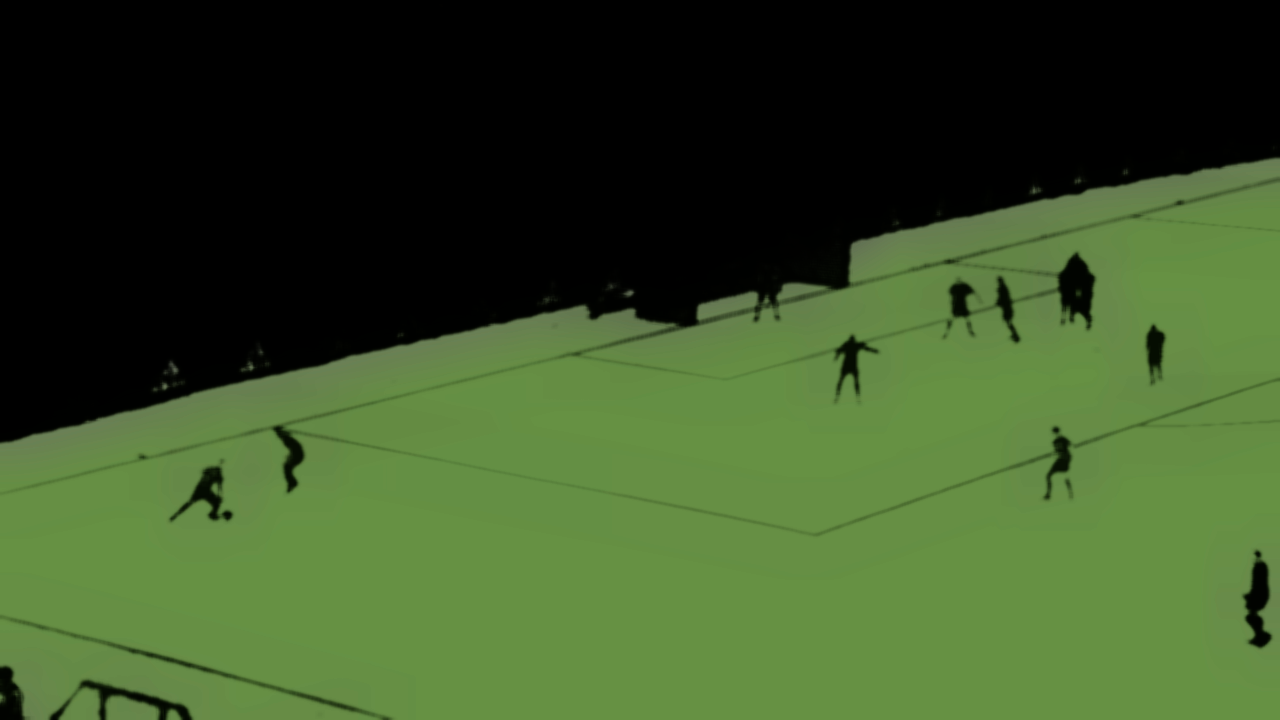

In [ ]:
img = first.copy()
# x,y,w,h=cv2.boundingRect(cnts[30])
# area=img[y:y+h, x:x+w] #selecting my ROI
# # cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,255), 2)
# cv2_imshow(area)
cv2_imshow(cv2.fastNlMeansDenoisingColored(layer3,None,100,100,7,100))


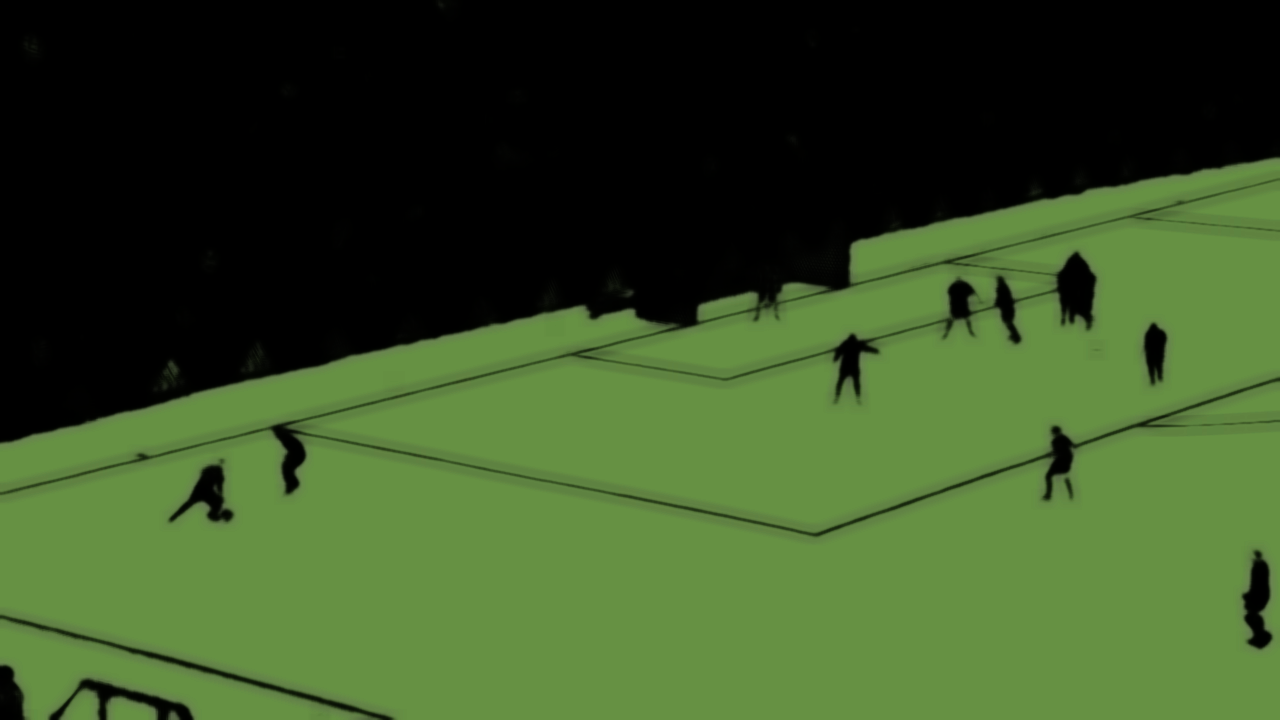

In [ ]:
cv2_imshow(cv2.fastNlMeansDenoisingColored(layer3,None,100,100,7,20))

In [ ]:
# https://vgg.fiit.stuba.sk/2015-04/detection-of-objects-in-soccer/

In [ ]:
# https://github.com/luncf/line-segment-detector
!pwd
!git clone https://github.com/luncf/line-segment-detector.git

/content
Cloning into 'line-segment-detector'...
remote: Enumerating objects: 28, done.
remote: Total 28 (delta 0), reused 0 (delta 0), pack-reused 28
Unpacking objects: 100% (28/28), done.


In [ ]:
!cd ./line-segment-detector/
!python ./line-segment-detector/src/vision.py

Traceback (most recent call last):
  File "./line-segment-detector/src/vision.py", line 6, in <module>
    from line_segment_detection import LineSegmentDetector
  File "/content/line-segment-detector/src/line_segment_detection.py", line 100, in <module>
    class LineSegmentDetector(CVMat):
  File "/content/line-segment-detector/src/line_segment_detection.py", line 101, in LineSegmentDetector
    __OPENCV_LSD = cv.createLineSegmentDetector(_refine=cv.LSD_REFINE_STD)
cv2.error: OpenCV(4.1.2) /io/opencv/modules/imgproc/src/lsd.cpp:143: error: (-213:The function/feature is not implemented) Implementation has been removed due original code license issues in function 'LineSegmentDetectorImpl'

